In [1]:
import numpy as np

In [2]:
with open('Xids_train.npy', 'rb')as fp:
    Xids = np.load(fp)

with open('Xmask_train.npy', 'rb')as fp:
    Xmask = np.load(fp)

with open('Labels_train.npy', 'rb')as fp:
    labels = np.load(fp)

In [3]:
Xids.shape

(9267, 512)

In [4]:
labels.shape

(9267, 5)

In [5]:
import tensorflow as tf 
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [7]:
def map_func(input_ids, mask, labels):
    return {'input_ids': input_ids, 'attention_mask': mask}, labels

In [8]:
dataset = dataset.map(map_func)

In [9]:
dataset = dataset.shuffle(100000).batch(32)

In [10]:
SEQ_LEN = 512
NUM_CLASS = 5

In [11]:
DS_LEN = len(list(dataset))
DS_LEN

290

In [12]:
SPLIT = .8
train = dataset.take(round(DS_LEN*SPLIT))
val = dataset.skip(round(DS_LEN*SPLIT))

In [13]:
val

<SkipDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [14]:
del dataset

In [15]:
del Xids
del Xmask
del labels

In [16]:
from transformers import TFAutoModel, TFAutoModelForSequenceClassification

e:\python_enviroments\envs\nlpenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# bert = TFAutoModel.from_pretrained('bert-base-cased')
bert = TFAutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-Spanish-wwm-cased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-Spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
NUM_CLASSES = 5

In [19]:
input_ids = tf.keras.layers.Input(shape= (SEQ_LEN, ), name= 'input_ids', dtype= 'int32')
mask = tf.keras.layers.Input(shape= (SEQ_LEN, ), name= 'attention_mask', dtype= 'int32')
embeddings = bert(input_ids, attention_mask= mask)[0]

# X = tf.keras.layers.GlobalMaxPool1D()(embeddings)

reshaped_embeddings = tf.keras.layers.Reshape((2, -1))(embeddings)
X = tf.keras.layers.GlobalMaxPool1D()(reshaped_embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
y= tf.keras.layers.Dense(5, activation='softmax', name= 'outputs')(X)

model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

model.layers[2].trainable = False

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109852418  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [21]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer = optimizer, loss = loss, metrics= [acc])

In [22]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath= 'Xception.h5')] #setting up early stopping

In [24]:
model.fit(
    train, validation_data= val, epochs=15, batch_size=32,callbacks=callbacks,
)

Epoch 1/15


232/232 [==============================] - 276s 1s/step - loss: 1.6021 - accuracy: 0.2346 - val_loss: 1.6105 - val_accuracy: 0.1970
Epoch 2/15
232/232 [==============================] - 255s 1s/step - loss: 1.6050 - accuracy: 0.2321 - val_loss: 1.5958 - val_accuracy: 0.2263
Epoch 3/15
232/232 [==============================] - 262s 1s/step - loss: 1.6017 - accuracy: 0.2247 - val_loss: 1.5924 - val_accuracy: 0.2480
Epoch 4/15
232/232 [==============================] - 260s 1s/step - loss: 1.6010 - accuracy: 0.2332 - val_loss: 1.5878 - val_accuracy: 0.2469
Epoch 5/15
232/232 [==============================] - 264s 1s/step - loss: 1.6021 - accuracy: 0.2280 - val_loss: 1.5906 - val_accuracy: 0.2859
Epoch 6/15
232/232 [==============================] - 261s 1s/step - loss: 1.6020 - accuracy: 0.2284 - val_loss: 1.5869 - val_accuracy: 0.2876
Epoch 7/15
232/232 [==============================] - 253s 1s/step - loss: 1.6026 - accuracy: 0.2303 - val_loss: 1.5784 - val_accuracy: 0.2973
Epoch 8/15

In [26]:
import os
filename= 'bert_model_512_v3.h5'

# Delete the file if it already exists
if os.path.exists(filename):
    os.remove(filename)
# Save the model
model.save(filename)

# validating and getting metrics

In [27]:
import pandas as pd

In [28]:
# Specify the file path where you want to save the CSV file
file_path = 'val_data.csv'
loaded_df = pd.read_csv(file_path)
loaded_df

,text,category
0,"¡ Hola ! Soy Ghita_Guerssel marroqui de fez , ...",A1
1,"Hola Manuela , Tengo un_poco de tiempo libre y...",A1
2,"Buenas días , Soy Tara , una visitante de los ...",A2
3,Me llamo Federico estoy escribiendo esté a la ...,C1
4,"Buenos dias , Por_favor , quiero reservar una ...",A2
...,...,...
2891,"Hola qué tal ? Soy soltero , tengo 7 hermanos ...",A1
2892,"Próhibo fumar en lugares públicos , es para mí...",B2
2893,¡ Hola ! Me llamo Mustapha . Mi familia es gra...,A1
2894,"Soy Sarah de Oran , quiero reservar una habita...",A2


In [29]:
from transformers import AutoTokenizer

#2847 Iis the max lenght of the texts
SEQ_LEN = 512

#i chose bert-base-cased because for me it's important to recognize the capital letters 
# in the text to identify the language level
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [30]:
Xids = []
Xmask = []

In [31]:
import numpy as np

Xids= np.zeros((len(loaded_df), SEQ_LEN))
Xmask= np.zeros((len(loaded_df), SEQ_LEN))

In [32]:
#casting text to String
loaded_df['text'] = loaded_df['text'].astype(str)

In [33]:
#checking type
for i, sequence in enumerate(loaded_df['text']):
    if not isinstance(sequence, str):
        print(f"Warning: 'text' at index {i} is not a string: {sequence}")

In [34]:
for i, sequence in enumerate(loaded_df['text']):
    encoded_token = tokenizer.encode_plus(
        sequence, 
        max_length= SEQ_LEN, 
        truncation= True, 
        padding= "max_length",
        add_special_tokens = True,
        return_token_type_ids = False,
        return_attention_mask = True,
        return_tensors = 'tf'
    )
    Xids[i,:], Xmask[i,:] = encoded_token['input_ids'],encoded_token['attention_mask']

In [35]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder to the unique category strings and transform the 'category' column
loaded_df['numerical_category'] = label_encoder.fit_transform(loaded_df['category'])

# Display the DataFrame with the new 'numerical_category' column
print(loaded_df[['category', 'numerical_category']])


     category  numerical_category
0          A1                   0
1          A1                   0
2          A2                   1
3          C1                   4
4          A2                   1
...       ...                 ...
2891       A1                   0
2892       B2                   3
2893       A1                   0
2894       A2                   1
2895       C1                   4

[2896 rows x 2 columns]


In [36]:
arr = loaded_df['numerical_category'].values
arr.size

2896

In [37]:
labels = np.zeros((arr.size, arr.max()+1))
labels.shape

(2896, 5)

In [38]:
labels[np.arange(arr.size), arr] = 1
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [39]:
saved_predictions = model.predict({'input_ids': Xids, 'attention_mask' : Xmask})
saved_predictions

91/91 [==============================] - 71s 749ms/step


array([[0.21532606, 0.19293718, 0.19602685, 0.22317193, 0.17253798],
       [0.21437171, 0.1878976 , 0.20057355, 0.2022861 , 0.19487104],
       [0.21517397, 0.1919368 , 0.19648041, 0.22146596, 0.1749428 ],
       ...,
       [0.21439433, 0.18759578, 0.19831614, 0.21417353, 0.18552023],
       [0.21184906, 0.20132507, 0.19223052, 0.22128414, 0.1733112 ],
       [0.21436872, 0.18795134, 0.20073025, 0.20142293, 0.1955268 ]],
      dtype=float32)

In [40]:
import numpy as np

# Assuming predictions is the array you provided
predictions = np.array(saved_predictions)

# Get the class label or index with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class labels
class_labels = ["A1", "A2", "B1", "B2", "C1"]
predicted_class


array([3, 0, 3, ..., 0, 3, 0], dtype=int64)

In [41]:
# Get the class label or index with the highest probability
true_labels = np.argmax(labels, axis=1)
true_labels

array([0, 0, 1, ..., 0, 1, 4], dtype=int64)

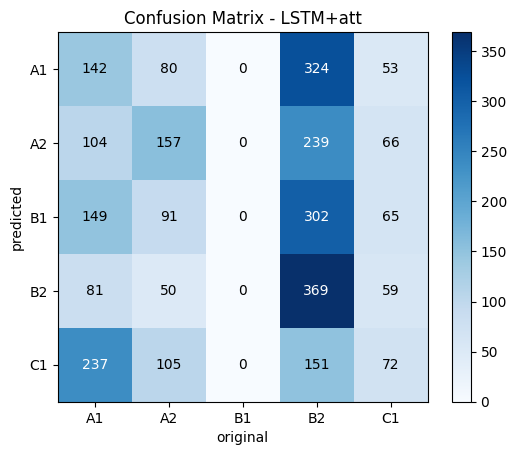

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_class)

# Display confusion matrix as a table
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['A1', 'A2', 'B1','B2', 'C1'])
ax.set_yticklabels(['A1', 'A2', 'B1','B2', 'C1'])
plt.xlabel("original")
plt.ylabel("predicted")

# Add values inside the confusion matrix cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Set font color based on the cell value
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

plt.title("Confusion Matrix")
plt.colorbar(im)
plt.show()

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_class, average='macro')
recall = recall_score(true_labels, predicted_class, average='macro')
f1 = f1_score(true_labels, predicted_class, average='macro')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.20384153329181456
Recall: 0.26039757829423016
F1-score: 0.21181242114151505


e:\python_enviroments\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
from sklearn.metrics import classification_report

# Get the class with the highest probability as the predicted class
predicted_classes = [np.argmax(pred) for pred in predictions]

# Generate the classification report
report = classification_report(true_labels, predicted_classes)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.20      0.24      0.22       599
           1       0.33      0.28      0.30       566
           2       0.00      0.00      0.00       607
           3       0.27      0.66      0.38       559
           4       0.23      0.13      0.16       565

    accuracy                           0.26      2896
   macro avg       0.20      0.26      0.21      2896
weighted avg       0.20      0.26      0.21      2896



e:\python_enviroments\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\python_enviroments\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\python_enviroments\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# kill kernel

import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 